In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import torch
from rpasim.ode import AB
from rpasim.ode.classic_control import PopulationDynamics, Lorenz, FlightControl, HIVTreatment
from rpasim.plot.ode import plot_trajectory
from rpasim.plot.env import plot_env_trajectory
from rpasim.env import DifferentiableEnv
import matplotlib.pyplot as plt

from rpasim.style import set_style
set_style()

# Test All Implemented ODEs

This notebook plots all implemented ODEs using both:
1. Direct ODE integration (plot_trajectory)
2. Environment simulation (plot_env_trajectory)

In [15]:
# Define ODE configurations
ode_configs = [
    {
        "ode": AB(),
        "x0": torch.tensor([1.0, 1.0]),
        "T": 100.0,
        "reward_fn": lambda state, t: -torch.norm(state[-1] - 4.0),
        "state_limits": None
    },
    {
        "ode": PopulationDynamics(),
        "x0": torch.tensor([50.0, 10.0]),
        "T": 100.0,
        "reward_fn": lambda state, t: -torch.norm(state - torch.tensor([100.0, 20.0])),
        "state_limits": None
    },
    {
        "ode": Lorenz(),
        "x0": torch.tensor([1.0, 1.0, 1.0]),
        "T": 10.0,
        "reward_fn": lambda state, t: -torch.norm(state),  # Q = I, minimize distance from origin
        "state_limits": None
    },
    {
        "ode": FlightControl(),
        "x0": torch.tensor([0.0, 0.0, 0.0]),
        "T": 13.0,
        "reward_fn": lambda state, t: -25.0 * state[0]**2,  # Q=25, track x1 to zero
        "state_limits": [(-0.2, 0.4), (-float('inf'), float('inf')), (-float('inf'), float('inf'))]
    },
    {
        "ode": HIVTreatment(),
        "x0": torch.tensor([1.0, 0.1, 0.05, 0.0, 0.01]),
        "T": 50.0,  # 50 weeks
        "reward_fn": lambda state, t: -(state[0] - 2.8) - (state[2] - 0.33),  # Track healthy steady state
        "state_limits": None
    }
]


AB (Integral Feedback)

Equations:
  dA/dt = 1.00 + 0.00*A + -0.25*B
  dB/dt = 4.00*A - 1.00*B
Parameters:
  alpha1 = 1.00, alpha2 = 0.00, alpha3 = -0.25
  beta1 = 4.00, beta2 = 1.00

Direct ODE Integration:


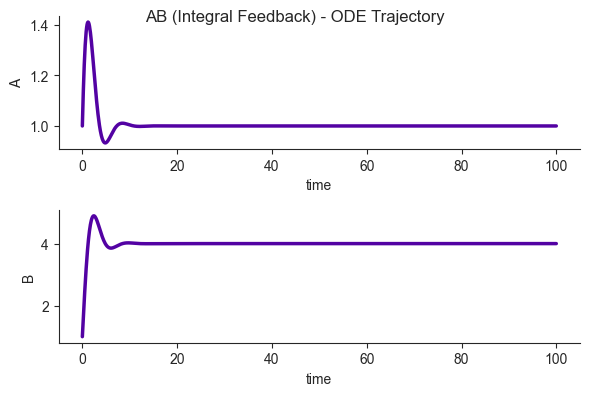


Environment Simulation:


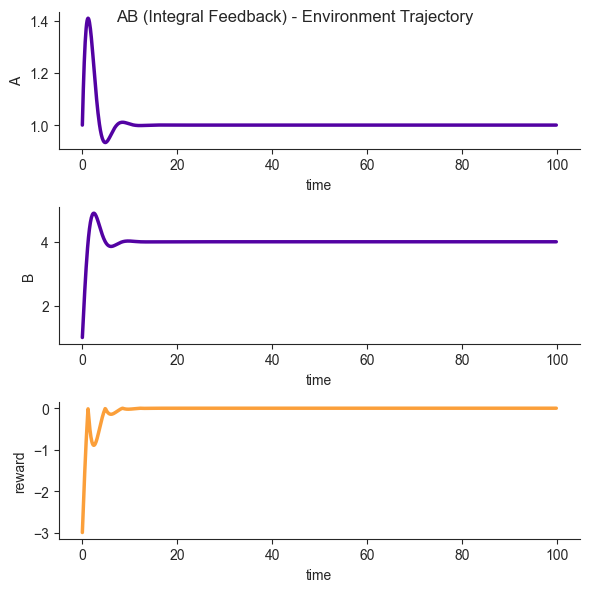


Total reward: -40.68

Population Dynamics (Lotka-Volterra)

Equations:
  dprey/dt = 0.50*prey - 0.03*prey*predator
  dpredator/dt = -0.50*predator + 0.00*prey*predator
Parameters:
  a = 0.50, b = 0.03, c = 0.50, d = 0.00

Direct ODE Integration:


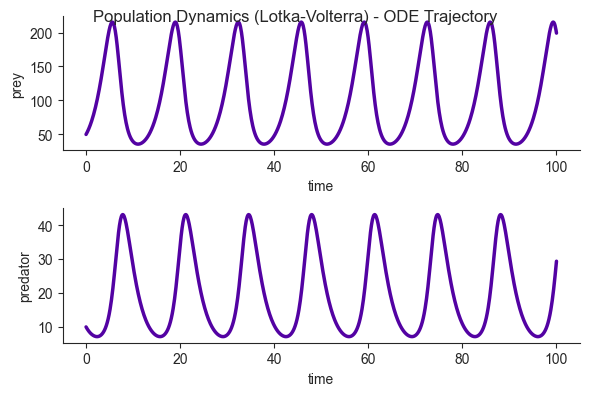


Environment Simulation:


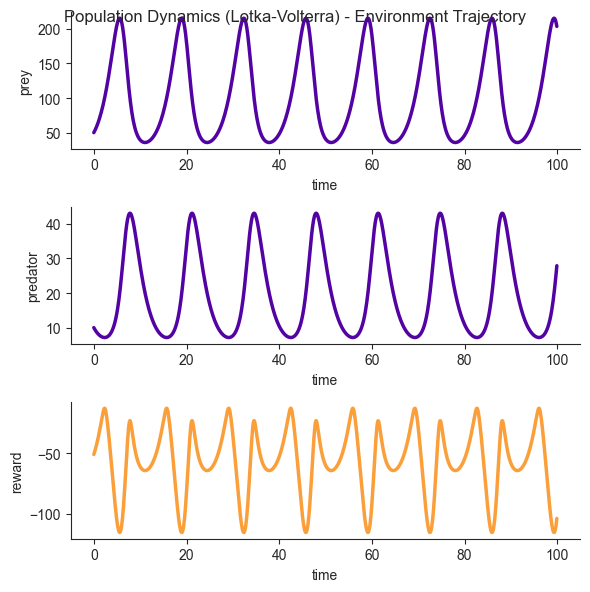


Total reward: -56441.86

Lorenz System (Chaotic)

Equations:
  dx1/dt = 10.00*(x2 - x1)
  dx2/dt = x1*(28.00 - x3) - x2
  dx3/dt = x1*x2 - 2.67*x3
Parameters:
  sigma = 10.00, beta = 2.67, rho = 28.00

Direct ODE Integration:


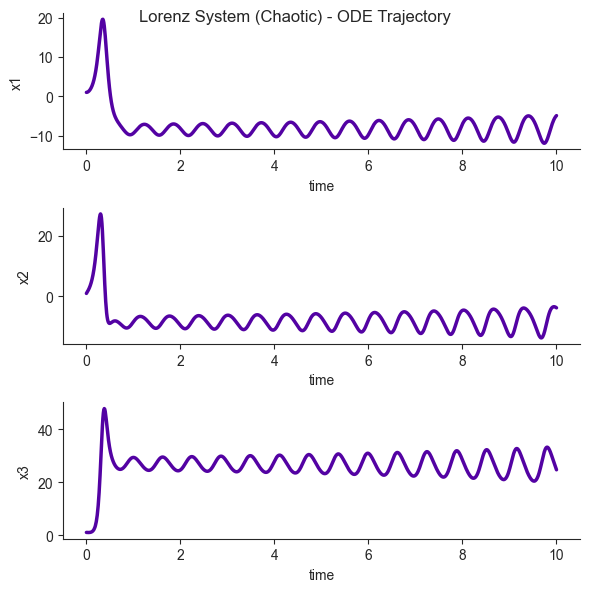


Environment Simulation:


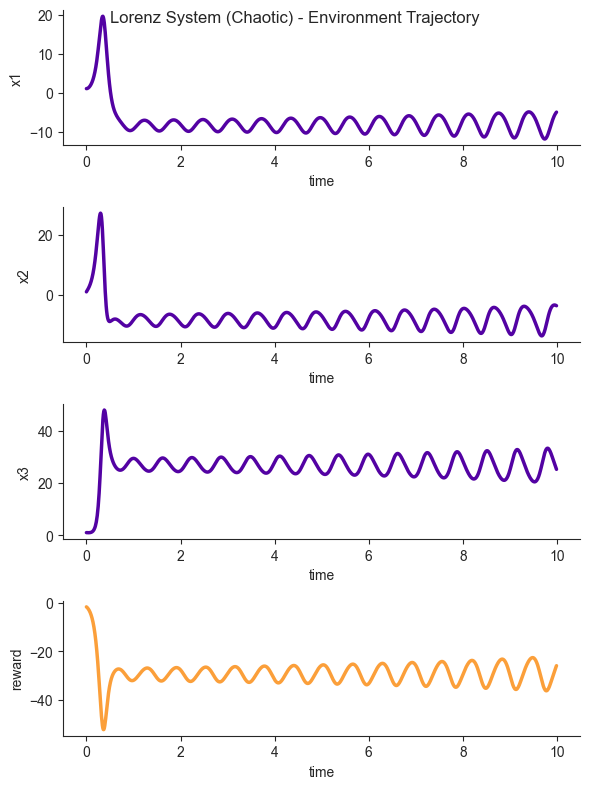


Total reward: -29077.45

Flight Control System

Equations (uncontrolled, u=0):
  dx1/dt = -0.88*x1 + 1.00*x3 + -0.09*x1*x3 + 0.47*x1² + -0.02*x2² + -1.00*x1²*x3 + 3.85*x1³
  dx2/dt = 1.00*x3
  dx3/dt = -4.21*x1 + -0.40*x3 + -0.47*x1² + -3.56*x1³
Control limits: u ∈ [-0.3, 0.5], State limit: x1 ∈ [-0.2, 0.4]

Direct ODE Integration:


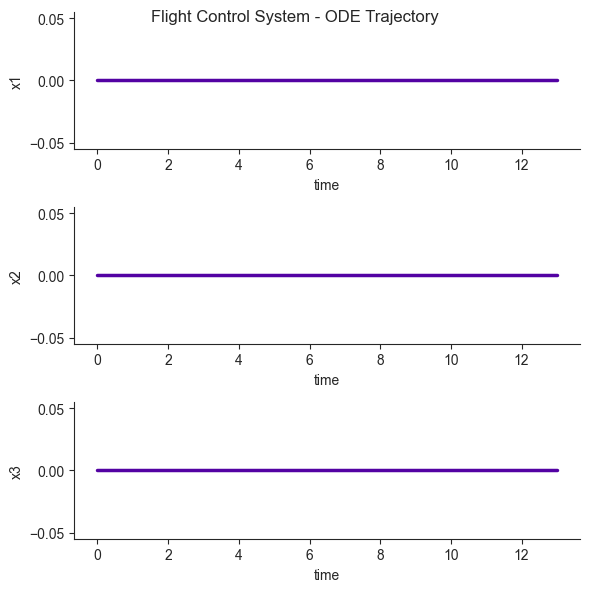


Environment Simulation:


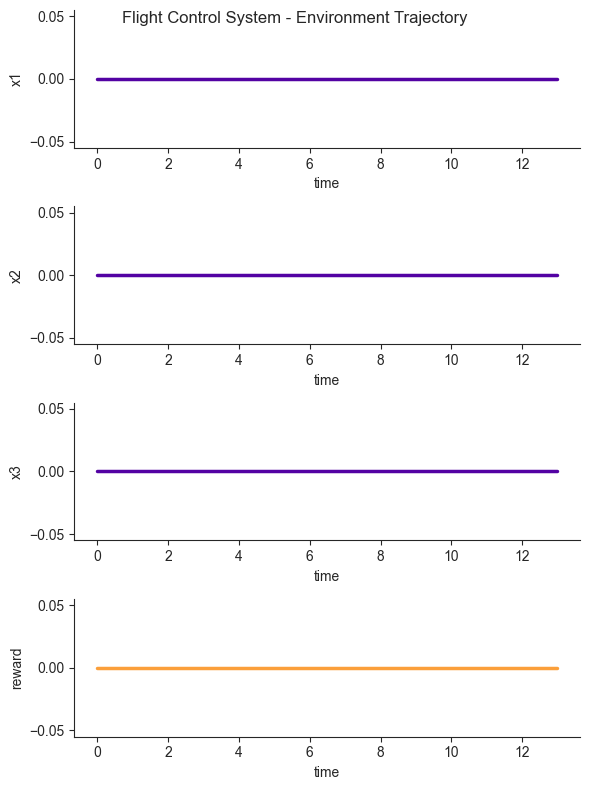


Total reward: 0.00

HIV/AIDS Treatment

Equations (uncontrolled, u=0):
  dx1/dt = 1.00 - 0.10*x1 - 1.00*x1*x2
  dx2/dt = 1.00*x1*x2 - 0.20*x2 - 1.00*x4*x2 - 1.00*x5*x2
  dx3/dt = 0.06*x1*x2*x3 - 0.06*0.50*x2*x3 - 0.01*x3
  dx4/dt = 0.03*x2*x4 - 0.10*x4
  dx5/dt = 0.06*0.50*x2*x3 - 0.10*x5
Control: u ∈ [0, 1], efficacy η = 0.9799, horizon = 50 weeks

Direct ODE Integration:


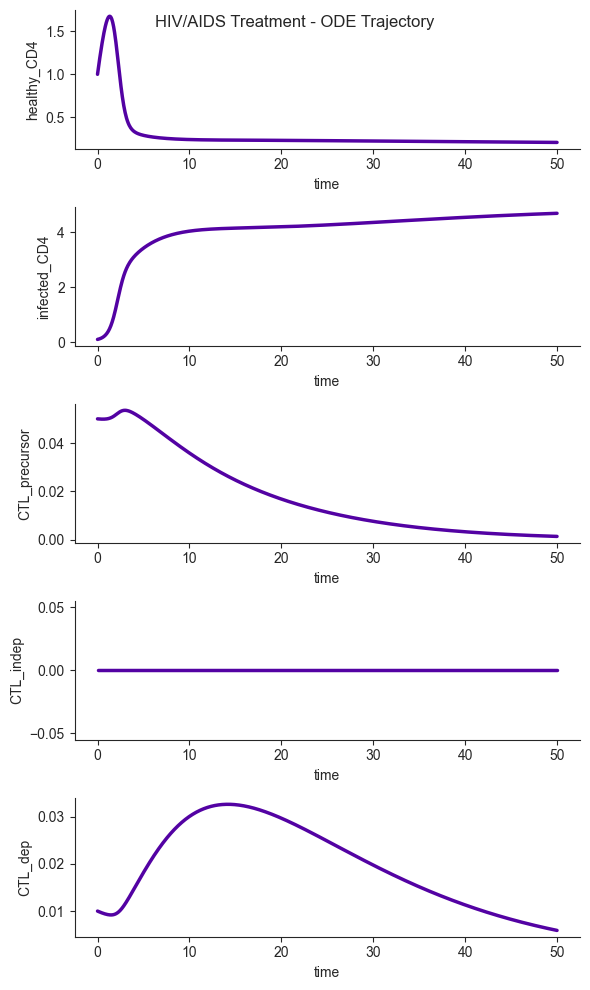


Environment Simulation:


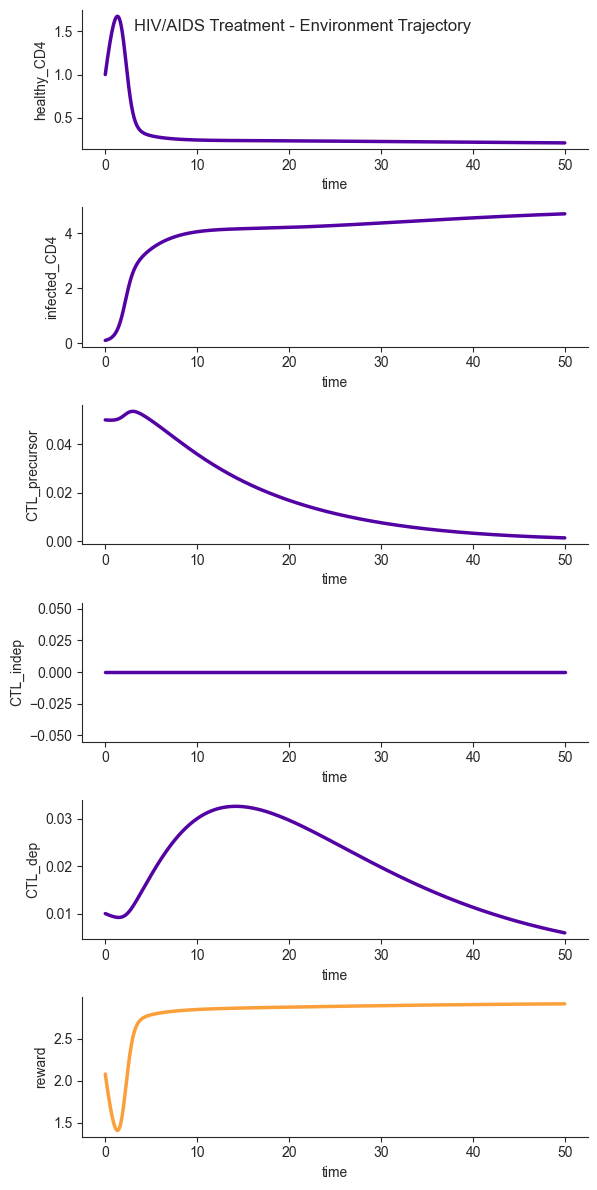


Total reward: 2814.64


In [16]:
# Plot all ODEs
for config in ode_configs:
    print(f"\n{'='*60}")
    print(config['ode'])
    print(f"{'='*60}")
    
    # 1. Plot using ODE trajectory
    print("\nDirect ODE Integration:")
    fig, axes = plot_trajectory(
        config['ode'],
        config['x0'],
        config['T'],
        n_steps=1000
    )
    fig.suptitle(f"{config['ode'].name} - ODE Trajectory")
    plt.show()
    
    # 2. Plot using environment
    print("\nEnvironment Simulation:")
    env = DifferentiableEnv(
        initial_ode=config['ode'],
        reward_fn=config['reward_fn'],
        initial_state=config['x0'],
        time_horizon=config['T'],
        state_limits=config.get('state_limits')
    )
    
    # Run environment
    env.reset()
    env.step((config['ode'], config['T']))
    
    # Plot
    fig, axes = plot_env_trajectory(env)
    fig.suptitle(f"{config['ode'].name} - Environment Trajectory")
    plt.show()
    
    print(f"\nTotal reward: {env.get_trajectory()[2].sum():.2f}")